In [1]:
%matplotlib notebook
import os, sys
import logging
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
from torch.utils.data import DataLoader
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
#from utils import data_ut as dut
# import custom classes
from MoDL_single import UnrolledModel
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from ImageFusion_Dualbranch_Fusion.densefuse_net import DenseFuseNet
from ImageFusion_Dualbranch_Fusion.channel_fusion import channel_f as channel_fusion
from torchvision.transforms.functional import adjust_contrast 
from fastmri.data import transforms, subsample
import ut2 as ut
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 0

In [2]:
!pwd

/home/taloved/.bashrc: line 5: ${BART TOOLBOX PATH}: bad substitution
/home/taloved/tal-lxc/tal/docker/MoDLsinglechannel/modl_singlechannel_reference


In [3]:
!which python3

/home/taloved/.bashrc: line 5: ${BART TOOLBOX PATH}: bad substitution
/home/taloved/env/bin/python3


In [4]:
# Path to your NIfTI file
# Original Slice
nii_file_target = './test_data/patient29b/T1_week152reg.nii'
nii_file_ref = './test_data/patient29b/T1_week165regT1_week152.nii'

# Good bew slice
#nii_file_target = './registered_data/patient28/T1_week25reg.nii'
#nii_file_ref = './registered_data/patient28/T1_week35regT1_week25.nii'

img_target = nib.load(nii_file_target)
img_ref = nib.load(nii_file_ref)
target = img_target.get_fdata()[...,20]
reference = img_ref.get_fdata()[...,20]
#target = img_target.get_fdata()[...,25]
#reference = img_ref.get_fdata()[...,25]


random_phase = torch.angle(T.random_map((1,256,160), 'cpu',kspace_radius_range=(0.001, 0.001))) 
target = target * (torch.exp(1j * random_phase)).numpy() 
target = target.squeeze(0)
target_torch = cplx.to_tensor(target).float() 
reference_torch = cplx.to_tensor(reference).float() 
reference_kspace_torch = T.fft2(reference_torch)
reference_kspace = cplx.to_numpy(reference_kspace_torch)
kspace_torch = T.fft2(target_torch)
target = cplx.to_numpy(target_torch)
kspace = cplx.to_numpy(kspace_torch)
mask2 = sp.mri.poisson((256,160),5, calib=(18,14), dtype=float, crop_corner=False, return_density=True, seed=0, max_attempts=6, tol=0.01)
mask2[128-10:128+9,80-8:80+7] = 1
mask_torch = torch.stack([torch.tensor(mask2).float(),torch.tensor(mask2).float()],dim=2)

mask_torch = T.kspace_crop(mask_torch,0.67)
kspace_torch = T.awgn_torch(kspace_torch,5,L=1)
kspace_torch = T.kspace_crop(kspace_torch,0.67)

kspace_torch = kspace_torch*mask_torch

s = (256/1.5)*(160/1.5)
print((torch.sum(mask_torch))/s)

tensor(0.6423)


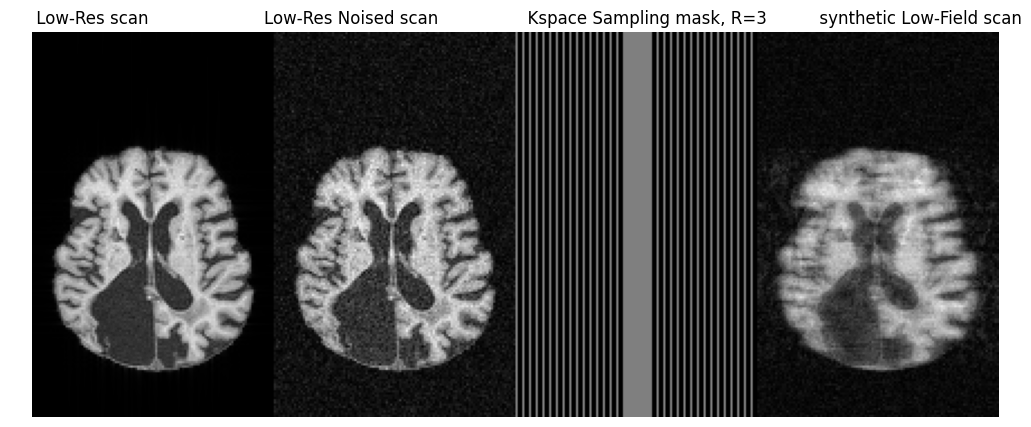

Mask torch size: (172, 108)
Acceleration factor R: 0.4074074074074074


In [5]:
im_lowres = abs(sp.ifft(sp.resize(sp.resize(kspace,(256,24)),(256,160))))
magnitude_vals = im_lowres.reshape(-1)
k = int(round(0.05 * magnitude_vals.shape[0]))
scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
kspace = kspace/scale
target = target/scale

# Apply kspace crop on target
target_torch = cplx.to_tensor(target)
target_torch = T.ifft2( T.kspace_cut(T.fft2(target_torch),0.67,0.67))
# For plot
kspace_HR = np.abs(cplx.to_numpy(T.fft2(cplx.to_tensor(target))))
kspace_LR =cplx.to_numpy( T.kspace_crop(T.fft2( cplx.to_tensor(target)),0.67))
target_HR = target
target_LR = cplx.to_numpy(T.ifft2( T.kspace_crop(T.fft2( cplx.to_tensor(target)),0.67)))
target = cplx.to_numpy(target_torch)
# Convert everything from numpy arrays to tensors
kspace_torch = cplx.to_tensor(kspace).float()
kspace_torch = T.awgn_torch(kspace_torch,10,L=1)
kspace_noised = kspace_torch.clone()
kspace_noised = T.kspace_cut(kspace_noised,0.67,0.67)
kspace_torch = T.kspace_cut(kspace_torch,0.67,0.67)
target_torch = cplx.to_tensor(target).float()

### Reference addition ###
im_lowres_ref = abs(sp.ifft(sp.resize(sp.resize(reference_kspace,(256,24)),(256,160))))
magnitude_vals_ref = im_lowres_ref.reshape(-1)
k_ref = int(round(0.05 * magnitude_vals_ref.shape[0]))
scale_ref = magnitude_vals_ref[magnitude_vals_ref.argsort()[::-1][k_ref]]
reference = reference / scale_ref
reference_torch = cplx.to_tensor(reference).float()
reference_torch_kspace = T.fft2(reference_torch)
reference_torch_kspace = T.kspace_cut(reference_torch_kspace,0.67,0.67)
reference_torch = T.ifft2(reference_torch_kspace)

from fastmri.data import transforms, subsample
def get_mask_func(factor):
    center_fractions = 0.08 * 4/factor # RandomMaskFunc EquiSpacedMaskFunc
    mask_func = subsample.EquiSpacedMaskFunc(
    center_fractions=[center_fractions],
    accelerations=[factor], 
    )
    return mask_func
mask_func = get_mask_func(3)
kspace_torch = transforms.apply_mask(kspace_torch, mask_func)[0]

concat = np.concatenate((target,cplx.to_numpy(T.ifft2(kspace_noised)),np.abs(cplx.to_numpy(kspace_torch))!=0,cplx.to_numpy(T.ifft2(kspace_torch))),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(concat), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title('     Low-Res scan                      Low-Res Noised scan                 Kspace Sampling mask, R=3          synthetic Low-Field scan')
plt.axis('off')
plt.show()

mask_np = np.abs(cplx.to_numpy(kspace_torch))!=0
print(f'Mask torch size: {mask_np.shape}')
s = (172)*(108)
print(f'Acceleration factor R: {np.sum(mask_np)/s}')

In [6]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [7]:
#Hyper parameters
params = Namespace()
#params.data_path = "./registered_data/patient23b/"
params.data_path = "./registered_data/"
params.batch_size = 2
params.num_grad_steps = 1 #4
params.num_cg_steps = 8 #8
params.share_weights = True
params.modl_lamda = 0.05
params.lr = 0.00001
#params.lr = 0.0001
params.weight_decay = 0
params.lr_step_size = 7
params.lr_gamma = 0.1
params.epoch = 61
params.reference_mode = 1
params.reference_lambda = 0.1

In [8]:
##### Paper use
# For first comparison -  
checkpoint_file_MoDL = "./checkpoints_10dB_paper/model_MoDLTests_100.pt" 

checkpoint_file_vit1 = "./checkpoints_10dB_paper/model_ViTSSIM_100.pt"
checkpoint_file_vit2 = "./checkpoints_10dB_paper/model_ViT_100.pt" 

checkpoint_file_vitfuser1 = "./checkpoints_10dB_paper/model_ViTFuser_100.pt"
checkpoint_file_vitfuser2 = "./checkpoints_10dB_paper/model_ViTFuserMSE_100.pt" 


checkpoint_MoDL = torch.load(checkpoint_file_MoDL,map_location=device)
checkpoint_vit1 = torch.load(checkpoint_file_vit1,map_location=device)
checkpoint_vit2 = torch.load(checkpoint_file_vit2,map_location=device)
checkpoint_vitfuser1 = torch.load(checkpoint_file_vitfuser1,map_location=device)
checkpoint_vitfuser2 = torch.load(checkpoint_file_vitfuser2,map_location=device)

params_MoDL = checkpoint_MoDL["params"]

from UnrolledViT import UnrolledViT
from UnrolledViTreg import UnrolledViTreg

model_vit1 = UnrolledViTreg(params).to(device)
model_vit2 = UnrolledViTreg(params).to(device)
model_vitfuser1 = UnrolledViT(params).to(device)
model_vitfuser2 = UnrolledViT(params).to(device)
model_MoDL = UnrolledModel(params_MoDL).to(device)

# load checkpoint
model_vit1.load_state_dict(checkpoint_vit1['model'])
model_vit2.load_state_dict(checkpoint_vit2['model'])
model_vitfuser1.load_state_dict(checkpoint_vitfuser1['model'])
model_vitfuser2.load_state_dict(checkpoint_vitfuser2['model'])
model_MoDL.load_state_dict(checkpoint_MoDL['model'])


/tmp/ipykernel_2259554/649985049.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_MoDL = torch.load(checkpoint_file_MoDL,map_location=device)
/tmp/ipykernel_2

shared weights


<All keys matched successfully>

In [9]:


img = cplx.to_tensor(np.abs(cplx.to_numpy(T.ifft2(kspace_torch)))).permute(2,0,1).unsqueeze(0).to(device)
img_chan = img[:,0,:,:].unsqueeze(0)
ref = cplx.to_tensor(np.abs(cplx.to_numpy(reference_torch))).permute(2,0,1).unsqueeze(0).to(device)
ref_chan = ref[:,0,:,:].unsqueeze(0)
ref_np = ref_chan.cpu().numpy()[0,0,:,:]
print(img_chan.shape)
img_padded_np = img_chan.cpu().numpy()[0,0,:,:]


## MoDL
im_out_MoDL = model_MoDL(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
print(im_out_MoDL.shape)
im_out_MoDL = np.abs(cplx.to_numpy(im_out_MoDL.cpu().detach()))
print(im_out_MoDL.shape)


## Vit1
im_out_vit1 = model_vit1(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
print(f'im_out_vit1 shape: {im_out_vit1.shape}')
im_out_vit1 = np.abs(cplx.to_numpy(im_out_vit1.cpu().detach()))
print(im_out_vit1.shape)

## Vit2
im_out_vit2 = model_vit2(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
print(f'im_out_vit2 shape: {im_out_vit2.shape}')
im_out_vit2 = np.abs(cplx.to_numpy(im_out_vit2.cpu().detach()))
print(im_out_vit2.shape)


## Vit fuser 1
im_out_vitfuser1 = model_vitfuser1(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
print(im_out_vitfuser1.shape)
im_out_pad = im_out_vitfuser1
print(im_out_pad.shape)
im_out_vitfuser1 = T.ifft2(T.fft2(im_out_pad))
target_torch = T.ifft2(T.fft2(cplx.to_tensor(target)))
target = cplx.to_numpy(target_torch.cpu().detach())
im_out_vitfuser1 = np.abs(cplx.to_numpy(im_out_vitfuser1.cpu().detach()))
print(im_out_vitfuser1.shape)

## Vit fuser 2
im_out_vitfuser2 = model_vitfuser2(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
print(im_out_vitfuser2.shape)
im_out_pad = im_out_vitfuser2
print(im_out_pad.shape)
im_out_vitfuser2 = T.ifft2(T.fft2(im_out_pad))
im_out_vitfuser2 = np.abs(cplx.to_numpy(im_out_vitfuser2.cpu().detach()))
print(im_out_vitfuser2.shape)


print(ref_np.shape)
print(img_padded_np.shape)
print(im_out_vit1.shape)
print(target.shape)


torch.Size([1, 1, 172, 108])


torch.Size([172, 108, 2])
(172, 108)
im_out_vit1 shape: torch.Size([172, 108, 2])
(172, 108)
im_out_vit2 shape: torch.Size([172, 108, 2])
(172, 108)
torch.Size([172, 108, 2])
torch.Size([172, 108, 2])
(172, 108)
torch.Size([172, 108, 2])
torch.Size([172, 108, 2])
(172, 108)
(172, 108)
(172, 108)
(172, 108)
(172, 108)


In [10]:
kspace_torch.shape
reference_torch.shape

torch.Size([172, 108, 2])

Size image: (172, 108)
Size ref: (172, 108)
Size mask: (172, 108)


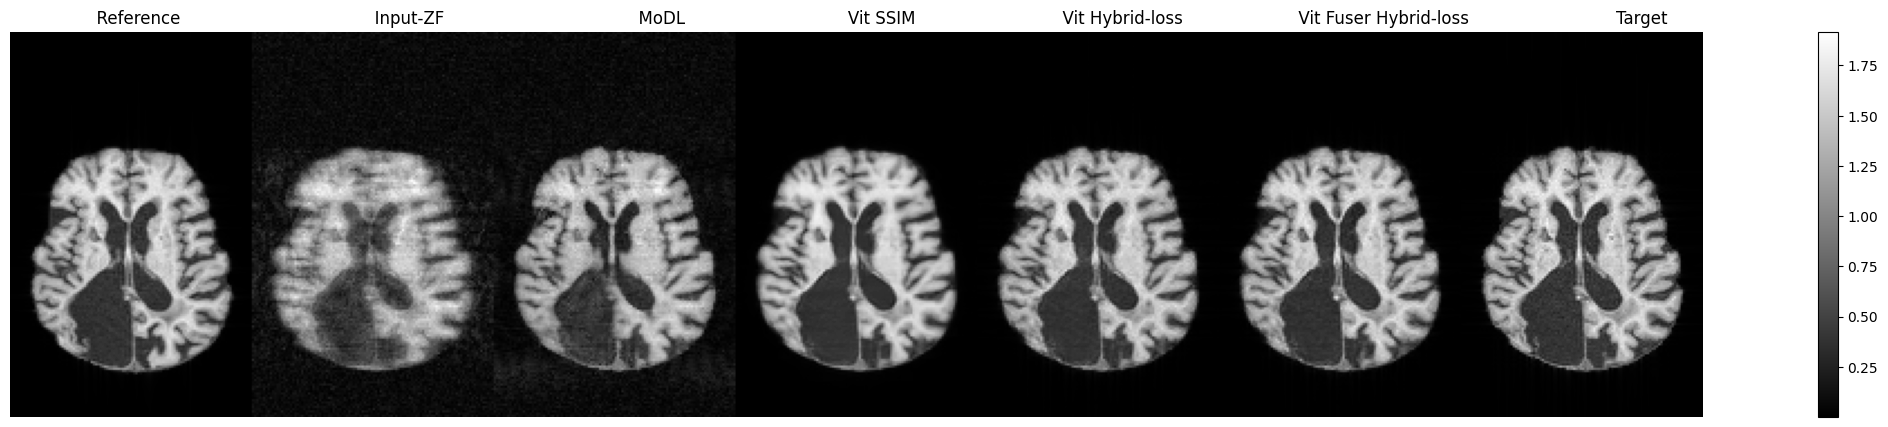

In [11]:
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import binary_fill_holes
def compute_psnr(img1, img2, maxval):
    """Computes PSNR in dB"""
    mse = np.mean((img1 - img2) ** 2)

    return (10 * np.log10(maxval / mse)).item()
cplx_image_target = target
cplx_image_in = img_padded_np
cplx_image_out_vit1 = im_out_vit1
cplx_image_out_vit2 = im_out_vit2
cplx_image_out_vitfuser1 = im_out_vitfuser1
cplx_image_out_vitfuser2 = im_out_vitfuser2

cplx_image_out_MoDL = im_out_MoDL

cplx_image_reference = ref_np
maxval = np.max(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out_vit1,cplx_image_out_vit2,cplx_image_out_vitfuser1,cplx_image_out_vitfuser2,cplx_image_out_MoDL),axis=0)))
minval = np.min(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out_vit1,cplx_image_out_vit2,cplx_image_out_vitfuser1,cplx_image_out_vitfuser2,cplx_image_out_MoDL),axis=0)))

## CS Lior Weizman
mask = np.abs(cplx.to_numpy(kspace_torch))!=0
print(f'Size image: {np.abs(cplx.to_numpy(T.ifft2(kspace_torch))).shape}')
print(f'Size ref: {(np.abs(cplx.to_numpy(reference_torch))).shape}')
print(f'Size mask: {mask.shape}')
target_shape = (256, 128)
def pad_array(array, target_shape):
    pad_height = (target_shape[0] - array.shape[0]) // 2
    pad_width = (target_shape[1] - array.shape[1]) // 2
    return np.pad(array, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
padded_input = pad_array(np.abs(cplx.to_numpy(T.ifft2(kspace_torch))), target_shape)
padded_ref = pad_array((np.abs(cplx.to_numpy(reference_torch))), target_shape)
padded_mask= pad_array(mask, target_shape)


adaptive_recon = ut.adaptive_CS_reconstruction(padded_input.copy(), padded_ref.copy(), 20,padded_mask.copy())

def crop_array(array, original_shape):
    crop_height = (array.shape[0] - original_shape[0]) // 2
    crop_width = (array.shape[1] - original_shape[1]) // 2
    return array[crop_height:crop_height + original_shape[0], crop_width:crop_width + original_shape[1]]

adaptive_recon_cropped = crop_array(adaptive_recon, np.abs(cplx.to_numpy(T.ifft2(kspace_torch))).shape)


plt_concat = np.concatenate((np.abs(cplx_image_reference),np.abs(cplx_image_in),np.abs(cplx_image_out_MoDL),np.abs(cplx_image_out_vit1),np.abs(cplx_image_out_vit2),np.abs(cplx_image_out_vitfuser1),np.abs(cplx_image_target)),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(30, 5))  # 1 row, 3 columns
im = axs.imshow(plt_concat, cmap='gray')
#axs.set_title(f'       Reference              Input-ZF (SSIM: {ssim_in:.2f})              MoDL (SSIM: {ssim_MoDL:.2f})                    Vit Fuser SSIM loss (SSIM: {ssim_ViT:.2f})               Vit Fuser feature+Style loss (SSIM: {ssim_ViT_style:.2f})                Vit Fuser SSIM+Style loss(SSIM: {ssim_ViT_style_test:.2f})              Target')
axs.set_title(f'          Reference                                     Input-ZF                                     MoDL                               Vit SSIM                            Vit Hybrid-loss                      Vit Fuser Hybrid-loss                            Target')
#axs.set_title(f'Reference                         Input                         Output                                 Target')
fig.colorbar(im, ax=axs)
plt.axis('off')
plt.show()
